# Prediction of a summer-cumulated streamflow for electrical production

To anticipate and optimize hydro-electricity production, the French compagny EDF carries out predictions of summer-cumulated streamflow (SCS) at the outlet of catchment areas where production units (dams) are located. SCS is defined as the streamflow cumulated between beginning of May and end of August (4 months). It essentially depends on the precipitation over the catchment area during Summer, and on the snowpack still present early May and melting during Summer. So, SCS indirectly depends on snow precipitation and melting during the previous Winter.

This notebook focuses on a catchment monitored by EDF since 1948 (at least partially). Precipitation, temperature and streamflow at the outlet are measured on a daily basis. Streamflow measurements started later. Sometimes, data are missing due to device misfunctioning or other external reasons. The goal is to develop a model able to predict SCS from precipitation and temperature data over the previous Winter and Summer, and streamflow data for Winter only.

The notebook presents an extended exploration and preparation of data, to handle missing data, separate seasons, etc. This first part should not need changes. Then the data are prepared for training/validating/testing, and a simple neural network is implemented with keras and tensorflow. This second part should be modified (just look at the results...).

The scientific problem is described in this paper: <https://doi.org/10.5194/hess-27-2283-2023>

In [1]:
import pandas as pd
import numpy as np
import csv
import copy

import numpy as np
from matplotlib import pyplot as plt

import seaborn as sns; sns.set()
#from sklearn.datasets import make_biclusters

# Part 1

## Read, explore, and first processing of data

The file contains dates, streamflow rate ($Q$), precipitation over the basin ($PS$), and temperature ($TS$). The time series starts in 1948 but there are gaps in the data. Typically, the streamflow rate was not measured during the first few years.

In [2]:
filename = "HydroBasinData.csv"
data = pd.read_csv(filename, index_col=0, parse_dates=True)

In [3]:
data.head()

,Q,PS,TS
1948-01-01,-9999.0,4.1,-10.9
1948-01-02,-9999.0,0.6,-7.2
1948-01-03,-9999.0,0.1,-3.7
1948-01-04,-9999.0,4.4,-2.9
1948-01-05,-9999.0,8.7,-5.8


In [4]:
data.tail()

,Q,PS,TS
2017-08-27,24.00,0.0,16.4
2017-08-28,24.50,0.0,18.8
2017-08-29,24.65,0.0,18.0
2017-08-30,25.00,3.5,16.2
2017-08-31,30.20,23.1,10.1


### Replace -9999 with nan

Missing values are replaced with -9999 in the file. In pandas DataFrame, we prefer NaN, because there are pandas functions specifically designed to manipulate NaNs.

In [5]:
data_nan = data.replace(-9999.0, np.nan)  # replace all -9999 values with Nan

### A few plots

We plot precipitation, streamflow, temperature over year 2017 (note it is not complete and there are missing values in July).

<AxesSubplot:>

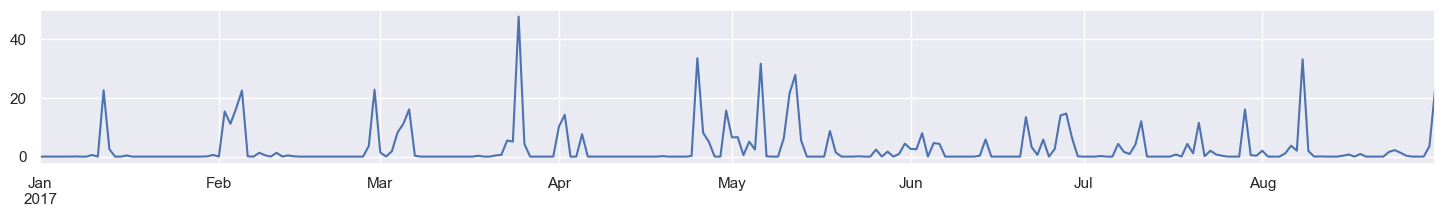

In [6]:
plt.figure(figsize=(18,2))
data_nan['PS']['2017'].plot()

<AxesSubplot:>

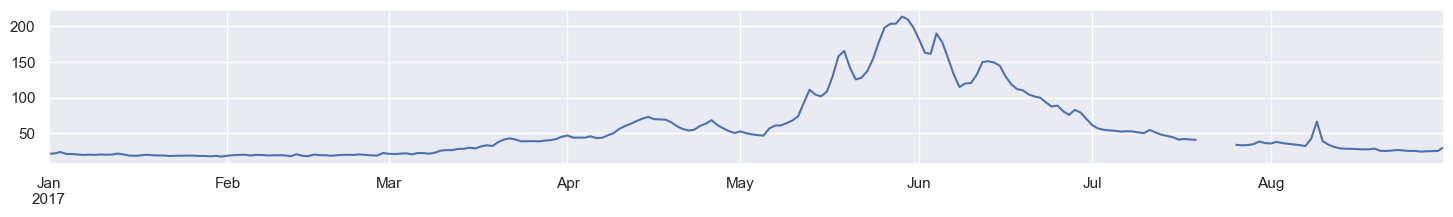

In [7]:
plt.figure(figsize=(18,2))
data_nan['Q']['2017'].plot()

<AxesSubplot:>

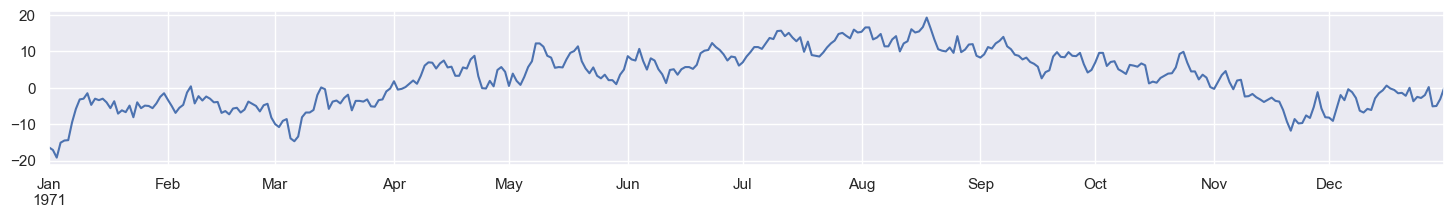

In [8]:
plt.figure(figsize=(18,2))
data_nan['TS']['1971'].plot()

In [9]:
data_nan

,Q,PS,TS
1948-01-01,NaN,4.1,-10.9
1948-01-02,NaN,0.6,-7.2
1948-01-03,NaN,0.1,-3.7
1948-01-04,NaN,4.4,-2.9
1948-01-05,NaN,8.7,-5.8
...,...,...,...
2017-08-27,24.00,0.0,16.4
2017-08-28,24.50,0.0,18.8
2017-08-29,24.65,0.0,18.0
2017-08-30,25.00,3.5,16.2


## Working with seasons

The winter season starts in december and ends in April. The Summer season starts in May and ends in August. To introduce this perspective and manipulate the data with respect to seasons, we create a new 'season' columns. One season runs from September to August (in fact, it is a year).

Then we rule out the seasons that miss too many data.

In [10]:
def summer_to_summer_season(df):
    """create a seasonal year in dataframe from September to August"""
    df['sea'] = df.index.year
    cond = df.index.month > 8 
    df['sea'] = np.where(cond,df.index.year+1,df.sea)
    return df

In [11]:
data_sea = summer_to_summer_season(data_nan)

<AxesSubplot:>

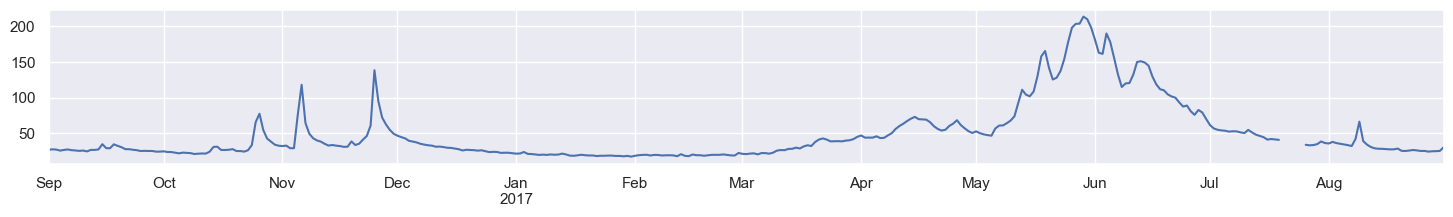

In [12]:
plt.figure(figsize=(18,2))
data_sea[data_sea['sea']==2017]['Q'].plot()

In [13]:
data_sea

,Q,PS,TS,sea
1948-01-01,NaN,4.1,-10.9,1948
1948-01-02,NaN,0.6,-7.2,1948
1948-01-03,NaN,0.1,-3.7,1948
1948-01-04,NaN,4.4,-2.9,1948
1948-01-05,NaN,8.7,-5.8,1948
...,...,...,...,...
2017-08-27,24.00,0.0,16.4,2017
2017-08-28,24.50,0.0,18.8,2017
2017-08-29,24.65,0.0,18.0,2017
2017-08-30,25.00,3.5,16.2,2017


### Remove seasons that contain too many NaNs and identify missing seasons

too many is 15 below

In [14]:
def rm_sparse_seasons(df, nb_nan):
    df_out = copy.deepcopy(df)
    seasons = set(df['sea'].tolist())
    for season in seasons:
        nbmax = 0
        for col in ['Q', 'PS', 'TS']:
            nbnans = df[df['sea']==season][col].isna().sum()
            nbmax = np.max((nbmax,nbnans))
        if nbmax > nb_nan:
            df_out.drop(df_out[df_out['sea'] == season].index, inplace = True)
        if nbmax > 0:
            print('There are nans in ',season)
    seasons = set(df_out['sea'].tolist())
    print('   ')
    print(seasons)
    print('   ')
    print(len(seasons), ' seasons left in the data')
    return df_out, seasons

In [15]:
data,seasons = rm_sparse_seasons(data_sea, 15)

There are nans in  1948
There are nans in  1949
There are nans in  1950
There are nans in  1951
There are nans in  1952
There are nans in  1953
There are nans in  1954
There are nans in  1955
There are nans in  1956
There are nans in  1957
There are nans in  1958
There are nans in  1959
There are nans in  1960
There are nans in  1970
There are nans in  2017
   
{1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017}
   
56  seasons left in the data


We note that 2017 contains nans but not enough to be ruled out. 1970 is ruled out.

### Missing seasons

We need to know the seasons missing between the first (1961) and the last (2017) for later purpose. More precisely, a built-in pandas functionality will reintroduce the missing dates in the time series, filling them with NaNs.

In [16]:
first, last = data.sea.iloc[0], data.sea.iloc[-1]
missing_seasons = [sea for sea in range(first, last+1) if sea not in seasons]

In [17]:
missing_seasons

[1970]

## Fill the Nans

Now that the seasons missing too many NaNs are ruled out, we must process those that miss only a few. In practice we must replace the NaNs with numbers.
We use the ```assign``` method because we want different filling methods for the different variables: 0 for missing values of precipitation, extrapolation for the others.

First we count the number of nans.

In [18]:
data.isna().sum()     # numbers of nans

Q      6
PS     0
TS     0
sea    0
dtype: int64

In [19]:
data = data.assign(Q=data.Q.ffill(), PS=data.PS.fillna(0), TS=data.TS.ffill() )

In [20]:
data.isna().sum()

Q      0
PS     0
TS     0
sea    0
dtype: int64

<AxesSubplot:>

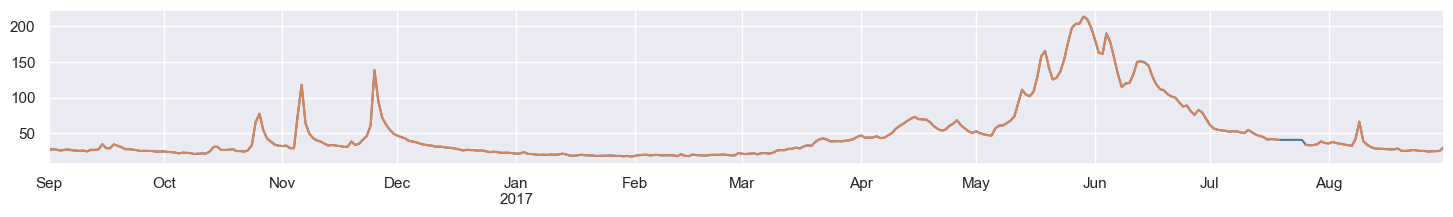

In [21]:
plt.figure(figsize=(18,2))
data[data['sea']==2017]['Q'].plot()
data_sea[data_sea['sea']==2017]['Q'].plot()

# Part 2

## Prepare data for the Neural Network

The goal is to predict the Summer (May-August) total streamflow from precipitation (Winter and Summer), temperature (Winter and Summer), and Winter (December-April) streamflow. **In this experiment, we consider monthly means and totals as inputs. This approximation must probably be reconsidered later.**

#### Inputs

* monthly means of winter temperature
* monthly means of summer temperature
* monthly total winter precipitation
* monthly total summer precipitation
* monthly total winter streamflow

#### Output

* Total Summer streamflow

### Compute monthly means and totals

Note that for temperature, monthly totals are nonsense. They are not used. Precipitation and streamflow means are not used either.

In [22]:
# Dataframe of the monthly sums (for Q and PS only)
sum_ = data.resample('M').sum()
sum_ = summer_to_summer_season(sum_)
# Dataframe of the monthly means (for TS)
mean_ = data.resample('M').mean()
mean_ = summer_to_summer_season(mean_)

The problem is that with resample we reintroduce the missing seasons. We must remove them again.

In [23]:
mean_.isna().sum()

Q      12
PS     12
TS     12
sea     0
dtype: int64

1970 was ruled out because of too many missing values, but it has been reintroduced by the resample function:

In [24]:
mean_[mean_['sea']==1970]

,Q,PS,TS,sea
1969-09-30,NaN,NaN,NaN,1970
1969-10-31,NaN,NaN,NaN,1970
1969-11-30,NaN,NaN,NaN,1970
1969-12-31,NaN,NaN,NaN,1970
1970-01-31,NaN,NaN,NaN,1970
1970-02-28,NaN,NaN,NaN,1970
1970-03-31,NaN,NaN,NaN,1970
1970-04-30,NaN,NaN,NaN,1970
1970-05-31,NaN,NaN,NaN,1970
1970-06-30,NaN,NaN,NaN,1970


### Remove again the missing seasons

In [25]:
for year in missing_seasons:
    mean_.drop(mean_[mean_['sea'] == year].index, inplace = True)
    sum_.drop(sum_[sum_['sea'] == year].index, inplace = True)

In [26]:
mean_.isna().sum()

Q      0
PS     0
TS     0
sea    0
dtype: int64

## Design training, validation and test datasets

As far as we can, we keep working with pandas Dataframe to benefit from the built-in functions. But at some point, we must convert the data into numpy arrays because keras takes numpy arrays as inputs.

We must normalize the data using the training data, and differently for temperature and precipitation. So it is better to normalize before transitioning from dataframe to arrays.

In [27]:
nb_sample = len(seasons)                       # total number of samples
nb_test = 5                                    # number of samples in the test dataset
nb_val = 5                                     # validation set
nb_train = nb_sample - nb_test - nb_val        # number of samples in training dataset

import random
permut_ = list(seasons)
random.shuffle(permut_)     # return a random permutation of the seasons. (seasons is a python set)

#### Seasons for test, validation, training

In [28]:
sea_test = permut_[0:nb_test]
sea_val = permut_[nb_test:nb_test+nb_val]
sea_train = permut_[nb_val+nb_test:]

#### Datasets in dataframe

In [29]:
df_mean_test = mean_.loc[mean_['sea'].isin(sea_test)]
df_mean_val = mean_.loc[mean_['sea'].isin(sea_val)]
df_mean_train = mean_.loc[mean_['sea'].isin(sea_train)]
df_sum_test = sum_.loc[mean_['sea'].isin(sea_test)]
df_sum_val = sum_.loc[mean_['sea'].isin(sea_val)]
df_sum_train = sum_.loc[mean_['sea'].isin(sea_train)]

## Make numpy arrays

In [30]:
summer_months, winter_months = [5,6,7,8], [12,1,2,3,4]
nb_summer, nb_winter = len(summer_months), len(winter_months)
nb_var = 3*nb_winter + 2*nb_summer

In [31]:
## Q arrays
q_winter_test = \
    df_sum_test[df_sum_test.index.month.isin(winter_months)]['Q'].values.reshape(nb_test,nb_winter)
q_summer_test = \
    df_sum_test[df_sum_test.index.month.isin(summer_months)]['Q'].values.reshape(nb_test,nb_summer).sum(axis=1)
q_winter_val = \
    df_sum_val[df_sum_val.index.month.isin(winter_months)]['Q'].values.reshape(nb_val,nb_winter)
q_summer_val = \
    df_sum_val[df_sum_val.index.month.isin(summer_months)]['Q'].values.reshape(nb_val,nb_summer).sum(axis=1)
q_winter_train = \
    df_sum_train[df_sum_train.index.month.isin(winter_months)]['Q'].values.reshape(nb_train,nb_winter)
q_summer_train = \
    df_sum_train[df_sum_train.index.month.isin(summer_months)]['Q'].values.reshape(nb_train,nb_summer).sum(axis=1)

## PS arrays
ps_winter_test = \
    df_sum_test[df_sum_test.index.month.isin(winter_months)]['PS'].values.reshape(nb_test,nb_winter)
ps_summer_test = \
    df_sum_test[df_sum_test.index.month.isin(summer_months)]['PS'].values.reshape(nb_test,nb_summer)
ps_winter_val = \
    df_sum_val[df_sum_val.index.month.isin(winter_months)]['PS'].values.reshape(nb_val,nb_winter)
ps_summer_val = \
    df_sum_val[df_sum_val.index.month.isin(summer_months)]['PS'].values.reshape(nb_val,nb_summer)
ps_winter_train = \
    df_sum_train[df_sum_train.index.month.isin(winter_months)]['PS'].values.reshape(nb_train,nb_winter)
ps_summer_train = \
    df_sum_train[df_sum_train.index.month.isin(summer_months)]['PS'].values.reshape(nb_train,nb_summer)

## TS arrays
ts_winter_test = \
    df_mean_test[df_mean_test.index.month.isin(winter_months)]['TS'].values.reshape(nb_test,nb_winter)
ts_summer_test = \
    df_mean_test[df_mean_test.index.month.isin(summer_months)]['TS'].values.reshape(nb_test,nb_summer)
ts_winter_val = \
    df_mean_val[df_mean_val.index.month.isin(winter_months)]['TS'].values.reshape(nb_val,nb_winter)
ts_summer_val = \
    df_mean_val[df_mean_val.index.month.isin(summer_months)]['TS'].values.reshape(nb_val,nb_summer)
ts_winter_train = \
    df_mean_train[df_mean_train.index.month.isin(winter_months)]['TS'].values.reshape(nb_train,nb_winter)
ts_summer_train = \
    df_mean_train[df_mean_train.index.month.isin(summer_months)]['TS'].values.reshape(nb_train,nb_summer)

## Normalization

### Normalization factors

In [32]:
norm_winter_mean_ts = ts_winter_train.mean(axis=0)
norm_winter_std_ts  = ts_winter_train.std(axis=0)
norm_winter_mean_ps = ps_winter_train.mean(axis=0)
norm_winter_std_ps  = ps_winter_train.std(axis=0)
norm_winter_mean_q = q_winter_train.mean(axis=0)
norm_winter_std_q  = q_winter_train.std(axis=0)

norm_summer_mean_ts = ts_summer_train.mean(axis=0)
norm_summer_std_ts  = ts_summer_train.std(axis=0)
norm_summer_mean_ps = ps_summer_train.mean(axis=0)
norm_summer_std_ps  = ps_summer_train.std(axis=0)
norm_summer_mean_q = q_summer_train.mean(axis=0)
norm_summer_std_q  = q_summer_train.std(axis=0)

### Normalization

In [33]:
ts_winter_train = (ts_winter_train - norm_winter_mean_ts) / norm_winter_std_ts
ps_winter_train = (ps_winter_train - norm_winter_mean_ps) / norm_winter_std_ps
q_winter_train = (q_winter_train - norm_winter_mean_q) / norm_winter_std_q

ts_summer_train = (ts_summer_train - norm_summer_mean_ts) / norm_summer_std_ts
ps_summer_train = (ps_summer_train - norm_summer_mean_ps) / norm_summer_std_ps
q_summer_train = (q_summer_train - norm_summer_mean_q) / norm_summer_std_q

ts_winter_val = (ts_winter_val - norm_winter_mean_ts) / norm_winter_std_ts
ps_winter_val = (ps_winter_val - norm_winter_mean_ps) / norm_winter_std_ps
q_winter_val = (q_winter_val - norm_winter_mean_q) / norm_winter_std_q

ts_summer_val = (ts_summer_val - norm_summer_mean_ts) / norm_summer_std_ts
ps_summer_val = (ps_summer_val - norm_summer_mean_ps) / norm_summer_std_ps
q_summer_val = (q_summer_val - norm_summer_mean_q) / norm_summer_std_q

ts_winter_test = (ts_winter_test - norm_winter_mean_ts) / norm_winter_std_ts
ps_winter_test = (ps_winter_test - norm_winter_mean_ps) / norm_winter_std_ps
q_winter_test = (q_winter_test - norm_winter_mean_q) / norm_winter_std_q

ts_summer_test = (ts_summer_test - norm_summer_mean_ts) / norm_summer_std_ts
ps_summer_test = (ps_summer_test - norm_summer_mean_ps) / norm_summer_std_ps
q_summer_test = (q_summer_test - norm_summer_mean_q) / norm_summer_std_q

In [34]:
ps_winter_val

array([[ 1.61613984e+00, -7.57201313e-02,  1.48743527e+00,
        -6.69409352e-01,  6.39315014e-04],
       [ 1.31836849e+00,  1.71370858e+00,  2.03288017e+00,
         2.45506139e-01,  7.17793735e-01],
       [-3.96435350e-01, -5.20023677e-01, -3.46875728e-01,
        -3.81441347e-01,  5.73330975e-01],
       [-7.03184728e-01,  5.40592548e-02,  3.07658152e-01,
         6.05877529e-01, -5.23898091e-01],
       [ 5.88155338e-01,  4.51031495e-01, -4.94347867e-01,
        -1.23711771e+00, -8.24862176e-01]])

### Create input and output numpy arrays

In [35]:
x_test = \
    np.concatenate((ts_winter_test, ps_winter_test, q_winter_test, ts_summer_test, ps_summer_test),axis=1)
y_test = q_summer_test
x_val = \
    np.concatenate((ts_winter_val, ps_winter_val, q_winter_val, ts_summer_val, ps_summer_val),axis=1)
y_val = q_summer_val
x_train = \
    np.concatenate((ts_winter_train, ps_winter_train, q_winter_train, ts_summer_train, ps_summer_train),axis=1)
y_train = q_summer_train

In [36]:
inshape = x_train.shape[1]

## Neural network


In [37]:
import tensorflow as tf
from tensorflow import keras

In [38]:
model = keras.models.Sequential()
model.add(keras.layers.Dense(16, activation='relu', input_shape=(inshape,)))
model.add(keras.layers.Dense(1))
model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])

history = model.fit(x_train, y_train,
                    epochs          = 500,
#                    batch_size      = 10,
                    verbose         = 0,
                    validation_data = (x_val, y_val))

In [39]:
history.history.keys()

dict_keys(['loss', 'mae', 'val_loss', 'val_mae'])

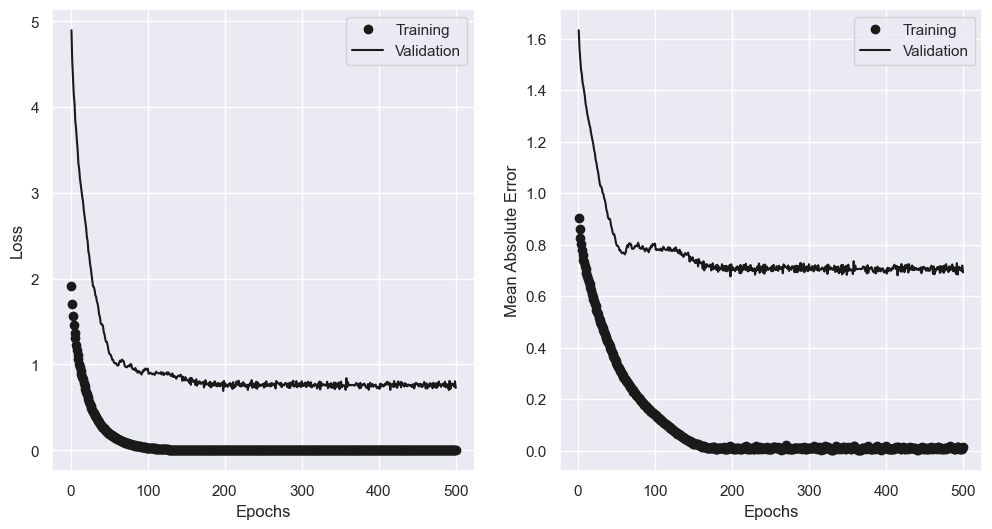

In [40]:
loss, val_loss = history.history['loss'], history.history['val_loss']
mae, val_mae = history.history['mae'], history.history['val_mae']
epochs = range(1, len(loss)+1 )

plt.figure(figsize=(12,6))
ax1 = plt.subplot(121)
#ax1.margins(0.05)           # Default margin is 0.05, value 0 means fit
ax1.plot(epochs, loss, 'ko', label = "Training" )
ax1.plot(epochs, val_loss, 'k', label = "Validation" )
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()

ax2 = plt.subplot(122)
#ax1.margins(0.05)           # Default margin is 0.05, value 0 means fit
ax2.plot(epochs, mae, 'ko', label = "Training" )
ax2.plot(epochs, val_mae, 'k', label = "Validation" )
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Mean Absolute Error')
ax2.legend()

The validation loss and MAE never meet the training. The model can probably not generalised to unseen data because of a too small training dataset. This was expected.
Let us have a look to predictions anyway (and confirm the poor model performance!)

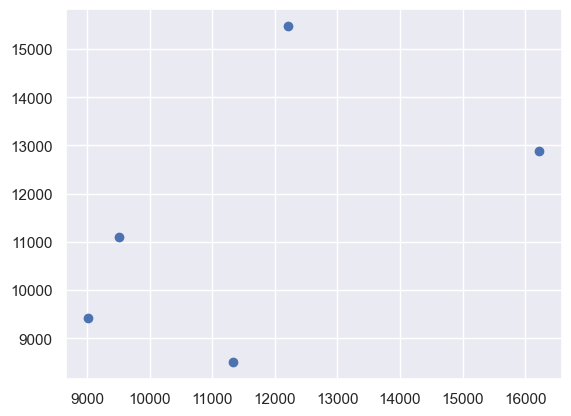

In [41]:
y_pred = model.predict(x_test)

y_pred = y_pred * norm_summer_std_q + norm_summer_mean_q
y_test_orig = y_test * norm_summer_std_q + norm_summer_mean_q

plt.plot(y_test_orig, y_pred, 'o')

## What next?

### What about using daily data?

Precipitation events with high temperatures in winter are critical for snowpack. Perhaps daily data should be used to incorporate the details of these events.

### Expand the database

The database is ridiculously small. It would be wise to use a K-fold cross-validation approach with randomization and iterations.

### Regularize the model

* with dropout
* or L1 or L2 regularization